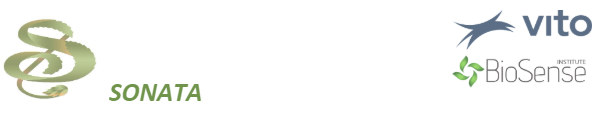
<br>
## training on VITO's hierarchical habitat mapping workflow for openEO processing platform
<br>
Copyrights, license and restrictions <br>
All code snippets, visualizations or/and workflow ideas are property of VITO. Work has been developed since 2021 and is still in development by VITO.
Showed public and private repositories are owned by VITO. <br>
(Re)sharing is only allowed with proper citation of the owners. Publications (peer-review, reports, ...) based partly and/or fully on VITO's hierarchical habitat mapping framework or on one of the provided GitHub repositories must be prior aligned with Dr. Marcel Buchhorn.
Code usage is allowed with proper citation, see author list in repository.
<br>
base repository: https://github.com/ESA-WEED-project/eo_processing

### Feature Selection

original script by: Dr. Marcel Buchhorn <br>
adatped by: Lori Giagnacovo

In [1]:
import os
import sys
import time
import optparse
from optparse import OptionParser
from ast import literal_eval
#extra official modules
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
#own modules
from SONATA.supporting_scripts.fnc_Grdana import cGrdana
from SONATA.supporting_scripts.fnc_boruta import BorutaPy
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pipelines'

In [2]:
NODATA_FEATURES = -32768

##### Specify the training data csv and the output folder for saving information about feature selection

In [5]:
# Have to insert somemthing for input
area = 'Pannonian'
path_training_csv = f'/data/habitat/serbia/BIOS_visit_march/models/v1/L1/data/{area}_v1_TP_EUNIS2021_2024_L1_all_features.csv' # path to csv in the data folder created in step 3a
output_folder = f'/data/habitat/EU_Habitat_Models/Base_year_2024_v1/Pannonian/models/v1/L1/data' # set output folder in same overarching folder as the data folder
sys.argv = ["notebook", "-t", f"{path_training_csv}", "-o", f"{output_folder}"]

# NOTE: in case the code cannot select features --> check the separability_scores.png --> select separability threshold visually (inflection point of curve) and specify in sys.argv also -s. E.g.: sys.argv = ["notebook", "-t", f"{path_training_csv}", "-o", f"{output_folder}", "-s", "0.10"]

##### Set the parameters for the feature selection module.
outlier_detection is set to False here cause this function still has to be optimized. It is currently running very slow.
but in the next step4 model generation there is also an outlier detection step.

In [4]:
def prepare_parameters(path_training, lColumns_feature_names, path_temp_folder, lHabitats):
    parameters = {'ground_ref_file': path_training,
                    'selected_features': lColumns_feature_names,
                    'selected_classes': lHabitats,
                    'outlier_detection': False,
                    'remove_intra_class_outliers': True,
                    'intra_rmse_threshold': 1.5,
                    'inter_rmse_threshold': 1,
                    'outlier_weight_threshold':0.5,
                    'select_best_bands': True,
                    'best_band_by_percentile': True,
                    'analysis_dir': path_temp_folder,
                    'nodata_value': NODATA_FEATURES}
    return parameters

##### Set the training data file in the right format for input.

In [5]:
def prepare_training(path_out_root, read_csv = None):
    # the identifier for a training point has to be named "entry"
    # the column containing the training point label has to be named "habitat"
    if read_csv is None:
        # Read training data
        raise NotImplementedError('the training data has to be given as CSV file')
    else:
        df = pd.read_csv(read_csv, index_col=0, dtype={'habitat': str})
        df.index.name = 'entry'

        #check if we have nan in the habitat column
        df = df[~pd.isna(df.habitat)]


        df = df.set_index('habitat', append=True)

        if 'lat' in df.columns:
            df.drop(columns='lat', inplace=True)

        if 'lon' in df.columns:
            df.drop(columns='lon', inplace=True)

        if 'x' in df.columns:
            df.drop(columns='x', inplace=True)

        if 'y' in df.columns:
            df.drop(columns='y', inplace=True)

        if 'Unnamed: 0' in df.columns:
            df.drop(columns='Unnamed: 0', inplace=True)

    # handle nodata and set to internal nodata value
    df.fillna(NODATA_FEATURES, inplace=True)

    #get names of features
    lColumns_features = df.columns.tolist()

    #reset index
    df.reset_index(inplace=True)

    #get names of habitats
    lHabitats = df.habitat.unique().tolist()

    #write out csv to disk
    path_out = os.path.join(path_out_root, 'training_data_habitat.csv')

    df.to_csv(path_out)

    return path_out, lColumns_features, lHabitats

##### Run a separability analysis to see which features can very well be separated from each other, and which ones are more alike

In [6]:
def runSeparability(parameters):
    try:
        print('*** run the separability analysis & outlier detection')
        # ini the object
        oGrdana = cGrdana(parameters)
        #run the analysis
        oGrdana.run()
        # get best bands
        path_bestbands = oGrdana.fBestFeatures
        path_outliers = oGrdana.fAllOutliers
        del oGrdana
    except:
        raise ValueError('problems to run the outlier detection and best band selection')
    return path_bestbands, path_outliers

##### if no separability score is specified in the command, this function will try to retrieve the optimal score itself.

In [7]:
def choose_separability_score_threshold(band_data, min_feat=10):
    """
    Automatic selection of suitable separability score-based threshold for the feature selection approach.

    parameters:
        band_data: list of separability scores sorted from the highest to the lowest
        min_feat: minimum number of features the selected threshold should preserve. default is 10
    returns:
        th: threshold to be set in order to run the best feature selection analysis
    """
    # We want to have at least 10 features after the thresholding, so we exclude the 10 best ranked features from the analysis
    sep_scores = band_data[min_feat:]

    # compute first order derivative
    smooth_d1 = np.gradient(sep_scores)

    # compute second order derivative
    smooth_d2 = np.gradient(smooth_d1)

    # compute crossing points
    zero_crossings = np.where(np.diff(np.sign(smooth_d2)))[0]

    # compute differences between sequential first order derivatives in correspondance or crossing points to find the max change
    slope_changes = [np.abs(smooth_d1[zero_crossings[i+1]] - smooth_d1[zero_crossings[i]]) for i in range(len(zero_crossings) - 1)]

    # steepest slope change
    max_index = np.argmax(slope_changes)

    # x y ranges where the max change occurs (the offset of the features removed at the beginning of the analysis is restored)
    x = [zero_crossings[max_index]+min_feat, zero_crossings[max_index+1]+min_feat]
    y = [band_data[x[0]], band_data[x[1]]]

    # compute threshold as mid point within the max slope change (taking into account the offset)
    th = (y[0]-y[1])/2 + y[1]

    return th

def calculate_inflection_point(scores):
    """
    Calculate the inflection point of an S-curve using second derivative analysis.

    Parameters:
        scores (list or array): List of separability scores sorted in descending order.

    Returns:
        inflection_index (int): The index of the inflection point in the scores list.
    """
    # Ensure the scores are a numpy array for efficient calculations
    scores = np.array(scores)

    # Compute first and second derivatives
    first_derivative = np.gradient(scores)
    second_derivative = np.gradient(first_derivative)

    # Identify zero crossings in the second derivative
    zero_crossings = np.where(np.diff(np.sign(second_derivative)))[0]

    if len(zero_crossings) == 0:
        print("No inflection point found.")
        return None

    # Return the first inflection point (can be adjusted for additional points)
    inflection_index = zero_crossings[0]
    return inflection_index


def plot_separability_scores(df_bestbands, output_dir, plot_filename="separability_scores.png"):
    """
    Plots separability scores for the features.

    parameters:
        df_bestbands: DataFrame containing feature names and their separability scores
        output_dir: directory to save the plot
        plot_filename: name of the output plot file
    """
    # Sort the bands by score in descending order
    df_sorted = df_bestbands.sort_values(by="score", ascending=False)

    scores = df_sorted["score"].tolist()

    # Calculate the inflection point
    inflection_index = calculate_inflection_point(scores)

    if inflection_index is not None:
        print(f"Inflection point is at index {inflection_index} with score {scores[inflection_index]:.2f}")
    else:
        print("No inflection point detected.")

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(df_sorted.index, df_sorted["score"], color="skyblue")
    plt.xlabel("Separability Score", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.title("Feature Separability Scores", fontsize=16)
    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, dpi=300)
    plt.close()
    print(f"Separability scores plot saved to {plot_path}")

##### Training data with features is prepared for the Boruta feature selection

In [8]:
def PrepareDataBoruta(path_TP, path_outliers, lColumns_features, path_best_bands):
    # prepare TD
    print('*** read in csv file...')
    df_TD = pd.read_csv(path_TP)
    df_TD.set_index('entry', inplace=True, verify_integrity = True)
    #filter out outliers from training data
    if os.path.isfile(path_outliers):
        with open(path_outliers) as f:
            # that ONLY WORKS as long Luc is writing out the outliers only as ONE line AND as FIRST line
            lOutliers_locationIDs = f.readline().strip()
        #to avoid errors if only one loaction_id is in the file we add an COMMA at the end
        lOutliers_locationIDs = lOutliers_locationIDs + ','
        try:
            #convert into list
            lOutliers_locationIDs = list(literal_eval(lOutliers_locationIDs))
        except:
            #if no outliers are in the file
            lOutliers_locationIDs = []
        #filter outliers out if still exists in dataframe
        df_TD = df_TD[~df_TD.index.isin(lOutliers_locationIDs)].copy()

    #prepare label column
    df_TD['label'] = df_TD['habitat'].copy()
    # keep only needed data in dataframe
    df_TD = df_TD[['label'] + lColumns_features]

    #get best bands in correct order
    with open(path_best_bands) as f:
        #now we have to find the right line
        lLines = [line.strip() for line in f]
    lBestBands = [x for x in lLines if x.startswith('bands')][0] # lBestBands empty
    lBestBands = list((lBestBands.split(': ')[1]).split(','))
    lScores = [x for x in lLines if x.startswith('Score')][0]
    lScores = list((lScores.split(': ')[1]).split(','))
    df_bestbands = pd.DataFrame(lScores, index=lBestBands, columns=['score'])
    df_bestbands['score'] = pd.to_numeric(df_bestbands['score'])

    # test - for features which have to many nan
    lFeatureRemove = []
    for pColumn in df_TD.columns:
        if pColumn == 'label':
            continue
        # number of NAN in dataset
        nSamples = df_TD[df_TD[pColumn] == NODATA_FEATURES].shape[0]
        if (nSamples / float(df_TD.shape[0])) > 0.25:
            lFeatureRemove.append(pColumn)
        else:
            # we fill with the average value to avoid issues in the boruta (increas in information context since extreme)
            df_TD.loc[df_TD[pColumn] == NODATA_FEATURES, pColumn] = np.nan
            df_TD[pColumn].fillna(df_TD[pColumn].mean(), inplace=True)
    # now remove Bad Features
    if len(lFeatureRemove) > 0:
        df_bestbands.drop(index=lFeatureRemove, inplace=True)
        df_TD.drop(columns=lFeatureRemove, inplace=True)

    return df_TD, df_bestbands


##### Boruta will select within the best bands (best predicting features) the bands that can best be separated.
It can take a default separability_score of 0.25 but this one can be set manually as well.
Normally the score is not specified in the command but in case the code breaks since it is not detecting the right score itself, it is best to check the output plot of the separability analysis and specify the score according to visually estimating the inflection point.
If less than 50 bands are selected, it will fill up with the 50 best bands. (minimum amount of 50 bands for model training and generation)

In [9]:
def runBoruta(df_TD, dfBestBands, separability_score=0.25):
    """ Helper function to run Boruta function on training data"""
    ##BorutaPy runs with numpy arrays to transfer data to it

    #Start with first test on features with the input separability score
    lBestBands = dfBestBands[dfBestBands.score > separability_score].index.tolist()

    aTrainingData = df_TD[lBestBands].values.copy()
    aMetricNames = np.array(lBestBands, dtype=np.str_) # first np.str0 ( DeprecationWarning: `np.str0` is a deprecated alias for `np.str_`.  (Deprecated NumPy 1.24) )
    aTrainingLabels = df_TD['label'].values.copy()

    # print the number of input features into Boruta
    print('*** run first Boruto with {} features'.format(len(lBestBands)))

    ###here we run a sanity check
    #if all TrainingLabels are the same - then we use the first 50 bands from M14a output
    if np.all(aTrainingLabels == aTrainingLabels[0]):
        print('** ATTENTION: All training labels are the same! There is only one class cluster or one cover fraction in this biome. Use Fallback for Boruta.')
        lFinal_Metric_Columns = lBestBands[:50]
    else:
        #ini the RandomForest Classifier needed for BrorutaPy
        rf = RandomForestClassifier(class_weight=None, max_depth=5, random_state=42)

        # define Boruta feature selection method
        feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, perc=99, max_iter=200, max_metrics = 60)
        # find all relevant metrics bands to solve the problem
        feat_selector.fit(aTrainingData, aTrainingLabels)

        #check that we have at minimum 50 selected Metric Bands if not run again with more BestBands
        if (feat_selector.n_features_ < 50):
            print('\n** Not enough selected features for the first round... run it again...')
            #now decrease the separability score
            lBestBands = dfBestBands[dfBestBands.score > (separability_score - 0.1)].index.tolist()

            aTrainingData = df_TD[lBestBands].values.copy()
            aMetricNames = np.array(lBestBands, dtype=np.str_) # first np.str0
            #run it again
            feat_selector.fit(aTrainingData, aTrainingLabels)
        else:
            pass

        #check that we have at minimum 50 selected Metric Bands if not run again with more BestBands
        if (feat_selector.n_features_ < 50):
            print('\n** Not enough selected features for the second round... run it again...')
            #now decrease the separability score
            lBestBands = dfBestBands[dfBestBands.score > (separability_score - 0.2)].index.tolist()

            aTrainingData = df_TD[lBestBands].values.copy()
            aMetricNames = np.array(lBestBands, dtype=np.str_) # first np.str0
            #run it again
            feat_selector.fit(aTrainingData, aTrainingLabels)
        else:
            pass

        #check that we have at minimum 50 selected Metric Bands if not run again with more BestBands
        if (feat_selector.n_features_ < 50):
            print('\n** STILL Not enough selected Metrics Bands for the third round... run it again...')
            #now we use all bands
            lBestBands = dfBestBands.index.tolist()

            aTrainingData = df_TD[lBestBands].values.copy()
            aMetricNames = np.array(lBestBands, dtype=np.str_) # first np.str0
            #run it again
            feat_selector.fit(aTrainingData, aTrainingLabels)
        else:
            pass

        #Final Check and choosing of metric band names
        if feat_selector.n_features_ < 50:
            print('\n** Damm - Still not enough chosen metric bands - fill up with first 50!!')
            #so we take the selected and add first 50 bands from the BestBands from Module 14a
            try:
                lFinal_Metric_Columns = feat_selector.transform(np.expand_dims(aMetricNames, 0)).squeeze().tolist()
                #check if everything worked
                if len(lFinal_Metric_Columns) == feat_selector.n_features_:
                    pass
                else:
                    raise
            except:
                print('*** Issues during feat_selector transformation - use fallback')
                lFinal_Metric_Columns = []
            #next get first 50 best bands
            lHelper = lBestBands[:50]
            #combine both in order first boruta outout and then fill up
            lFinal_Metric_Columns = (lFinal_Metric_Columns + [x for x in lHelper if x not in lFinal_Metric_Columns])[:50]
        else:
            print('\n** Select the final metric bands for the scenario')
            lFinal_Metric_Columns = feat_selector.transform(np.expand_dims(aMetricNames, 0)).squeeze().tolist()
            #check if everything worked
            if len(lFinal_Metric_Columns) == feat_selector.n_features_:
                pass
            else:
                raise
    return lFinal_Metric_Columns

In [10]:
def main(options):
    #output folder
    path_out = os.path.normpath(options.path_output_root)
    # create folder if needed
    os.makedirs(path_out, exist_ok=True)

    #prepare training data and save as CSV file in correct specifications
    # also get the list of Features and all the class labels (habitats)
    path_given_training_data = os.path.normpath(options.path_training)
    path_TP, lColumns_features, lHabitats = prepare_training(path_out, read_csv=path_given_training_data)

    # 1. run the separability analysis to get the features with the highest separability
    #setup parameters for Grdana run
    parameters = prepare_parameters(path_TP, lColumns_features, path_out, lHabitats)
    #run Grdana
    path_best_bands, path_outliers = runSeparability(parameters)

    # 2. run the boruta for information content & redundancy analysis
    # prepare needed data
    df_TD, df_bestbands = PrepareDataBoruta(path_TP, path_outliers, lColumns_features, path_best_bands)

    # automatic detection of separability score if needed
    if options.separability_score == 'auto':
        lScores = df_bestbands.score.tolist()
        threshold = choose_separability_score_threshold(lScores)
        # we start with a score above the turning point since boruta will adapt the score if too few bands are selected
        sep_score = threshold + 0.05
        #sep_score = threshold
    else:
        sep_score = options.separability_score

    plot_separability_scores(df_bestbands, path_out)

    ### Part D: run Boruta approach
    print('* run the Boruta approach for final selection of Best Metric Bands ...')
    try:
        lFinal_Metric_Columns = runBoruta(df_TD, df_bestbands, separability_score=sep_score)
    except Exception:
        raise IOError('** Could not correctly run Boruta approach!')

    # write out results
    sFile_basename = os.path.basename(options.path_training).split('.csv')[0]
    path_file_out = os.path.join(path_out, sFile_basename+'-selectedFeatures.txt')
    try:
        with open(path_file_out, 'w') as f:
            f.write('selected_features: ' + ','.join([str(x) for x in lFinal_Metric_Columns]) + '\n')
    except Exception:
        raise IOError('** problems during config file writing!')

In [11]:
if __name__ == '__main__':
    # check if right Python version is available.
    assert sys.version_info[0:2] >= (3,6), "You need at minimum python 3.6 to execute this script."
    start_time = time.time()
    # ini the Option Parser
    parser = optparse.OptionParser(formatter=optparse.TitledHelpFormatter(), usage=globals()['__doc__'], version="%prog v4.4")
    parser.add_option ('-t', '--path_training', help='Path to the training data CSV file. (need column=habitat & column=entry)') # script Bruno necessary (habitat_TP)?
    parser.add_option ('-o', '--path_output_root', help='Path to the output root directory.')
    parser.add_option ('-s', '--separability_score', default='auto', help='Value between 0 - 1. Overwrites the automatic detection.')

    # parse the given system arguments
    (options, args) = parser.parse_args()

    # do checks on the parsed options
    if (not options.path_training) or (not os.path.isfile(os.path.normpath(options.path_training))):
        parser.error ("the -t argument for the training data file is missing or the given path doesn't exist!!!")
    if (not options.path_output_root):
        parser.error ("the -o argument for the output root folder has to specified!!!")
    if len(args) != 0:
        parser.error ('too many arguments')

    if options.separability_score != 'auto':
        try:
            options.separability_score = float(options.separability_score)
        except:
            parser.error ("the -s argument must be a value between 0 - 1!")
        if (options.separability_score < 0) or (options.separability_score > 1.0):
            parser.error ("the -s argument must be between 0 - 1!")


Usage
=====
  Automatically created module for IPython interactive environment

notebook: error: the -t argument for the training data file is missing or the given path doesn't exist!!!


SystemExit: 2

/home/lorigiagnacovo/.conda/envs/weed2/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


#### For level 1

##### If you get error: ValueError: Found array with 0 feature(s) (shape=(81935, 0)) while a minimum of 1 is required.
--> Check the separability_scores.png and select the separability threshold yourself by identifying the inflection point of the curve visually. Go back to specify input and specify -s.

#### For level 2 and 3, we need adjusted commands and an automatic way to generate them

In [14]:
from pathlib import Path
level = 1
area = 'Pannonian'
root = Path(f'/data/habitat/serbia/BIOS_visit_march/models/v1/L{level}/') # path to level folder within models folder
if level == 1:
    # Simulate the command-line arguments
    path_training_csv = f'{root}/data/{area}_v1_TP_EUNIS2021_2024_L1_all_features.csv' # path to csv in the data folder
    output_folder = f'{root}/data' # path to data folder
    sys.argv = ["notebook", "-t", f"{path_training_csv}", "-o", f"{output_folder}"]
    print('START OF MODULE: Feature selection')
    print(time.asctime())
    # call main function - "options" object is set to global object
    main(options)

    print(time.asctime())
    print('END OF MODULE: Feature selection. Have a nice day.')
else:
    # 3. Clean the `sys.argv` right at the start
    # Clear sys.argv completely
    sys.argv = ['notebook']
    classes_to_process = set()
    for f in root.glob("*class-*"):
        cl = str(f).split('-')[-1]
        classes_to_process.add(cl)
    for cl in classes_to_process:
        dest_in = Path(f'/data/habitat/serbia/BIOS_visit_march/models/v1/v1/L{level}/class-{cl}/data') # path to data folder for level 2 or level 3 classes
        dest = Path(f'/data/habitat/serbia/BIOS_visit_march/models/v1/L{level}/class-{cl}/data') # path to data folder for level 2 or level 3 classes
        csv_files = list(dest_in.glob(f'*_L{level}_*.csv'))
        #print(f"Processing files in: {dest}")
        if not csv_files:
            print(f"No CSV files found in: {dest}")
        else:
            for csv_file in csv_files:
                csv_file_name = os.path.basename(csv_file)
                # Generate sys.argv dynamically for each combination
                args = ["notebook", "-t", str(dest_in / csv_file_name), "-o", str(dest)]
                #print(f"{str(dest / csv_file_name)} {str(dest)}\n")
                #print(f'["notebook", "-t", f"{str(dest / csv_file_name)}", "-o", f"{str(dest)}\n"]')
                print(f"Running with args: {args}")

                # Update sys.argv for this combination
                sys.argv = args
                # Call the main function to process the data
                print(f'START OF MODULE for class-{cl}: Feature selection')
                print(time.asctime())
                # call main function - "options" object is set to global object
                main(options)

                print(time.asctime())
                print(f'END OF MODULE for class-{cl}: Feature selection. Have a nice day.')

Running with args: ['notebook', '-t', '/data/habitat/EU_Habitat_Models/Base_year_2024_v1/Continental/models/v1/L2/class-N/data/Continental_v1_TP_EUNIS2021_2024_L2_N_all_features.csv', '-o', '/data/habitat/EU_Habitat_Models/Base_year_2024_v1/Continental/models/v1/L2/class-N/data_test']
START OF MODULE for class-N: Feature selection
Fri Mar  7 12:29:50 2025
*** run the separability analysis & outlier detection
** run Input data check...
** Processing file: /data/habitat/EU_Habitat_Models/Base_year_2024_v1/Continental/models/v1/L1/data_test/training_data_habitat.csv
** run the best bands selection...
*** retrieve Class/Metrics info for analysis...


ValueError: problems to run the outlier detection and best band selection

### Currently, running this script for level 2 and level 3 has an error and unoperational. Please run the scripts in step3b_feature_selection_scripts for feature selection of level 2 and level 3.